In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

START_DATE = "2009-10-27" # First day filtering
END_DATE = "2019-10-22" # Last day filtering

In [2]:
class TeamObject:
    # Static season dates dictionary
    SEASON_DATES = {
        "2009-10": {"start": "2009-10-27", "end": "2010-06-17"},
        "2010-11": {"start": "2010-10-26", "end": "2011-06-12"},
        "2011-12": {"start": "2011-12-25", "end": "2012-06-21"},
        "2012-13": {"start": "2012-10-30", "end": "2013-06-20"},
        "2013-14": {"start": "2013-10-29", "end": "2014-06-15"},
        "2014-15": {"start": "2014-10-28", "end": "2015-06-16"},
        "2015-16": {"start": "2015-10-27", "end": "2016-06-19"},
        "2016-17": {"start": "2016-10-25", "end": "2017-06-12"},
        "2017-18": {"start": "2017-10-17", "end": "2018-06-08"},
        "2018-19": {"start": "2018-10-16", "end": "2019-06-13"}
    }

    def __init__(self, name, id, conference):
        self.name = name
        self.id = id
        self.conference = conference
        self.games = {}

    @staticmethod
    def convert_to_datetime(date_input):
        """
        Convert various date formats to datetime object
        """
        if isinstance(date_input, pd.Timestamp):
            return date_input.to_pydatetime()
        elif isinstance(date_input, str):
            return datetime.strptime(date_input, "%Y-%m-%d")
        elif isinstance(date_input, datetime):
            return date_input
        else:
            raise ValueError(f"Unsupported date format: {type(date_input)}")

    @classmethod
    def get_season_dates(cls, season):
        """
        Get the start and end dates for a specific season
        Args:
            season (str): Season in format "YYYY-YY"
        Returns:
            dict: Dictionary containing start and end dates for the season
        """
        return cls.SEASON_DATES.get(season)

    @classmethod
    def is_date_in_season(cls, date_input, season):
        """
        Check if a given date falls within a specific season
        Args:
            date_input: Date in string, Timestamp, or datetime format
            season (str): Season in format "YYYY-YY"
        Returns:
            bool: True if date is within season, False otherwise
        """
        season_dates = cls.get_season_dates(season)
        if not season_dates:
            return False
        
        date = cls.convert_to_datetime(date_input)
        season_start = datetime.strptime(season_dates["start"], "%Y-%m-%d")
        season_end = datetime.strptime(season_dates["end"], "%Y-%m-%d")
        
        return season_start <= date <= season_end

    def get_games_by_season(self):
        """
        Organizes team's games by season.
        Returns:
            list: List of dictionaries where each dictionary contains games for a season
                  with keys formatted as 'season_teamname'
        """
        seasons_games = []
        
        for season in self.SEASON_DATES:
            season_dict = {f"{season} {self.name}": []}
            
            # Go through all games and check if they belong to this season
            for game_date, game_data in self.games.items():
                if self.is_date_in_season(game_date, season):
                    # Convert Timestamp to string format if needed
                    date_str = game_date
                    if isinstance(game_date, pd.Timestamp):
                        date_str = game_date.strftime("%Y-%m-%d")
                    
                    season_dict[f"{season} {self.name}"].append({
                        "date": date_str,
                        **game_data  # Include all other game data
                    })
            
            # Only append if there are games in this season
            if season_dict[f"{season} {self.name}"]:
                seasons_games.append(season_dict)
        
        return seasons_games

In [3]:
# Teams in NBA based on dataset
WESTERN_CONFERENCE_TEAMS = {'Portland Trail Blazers', 'Los Angeles Lakers', 'Dallas Mavericks', 'Golden State Warriors', 'Denver Nuggets', 'Los Angeles Clippers', 'San Antonio Spurs', 'Minnesota Timberwolves', 'Memphis Grizzlies', 'New Orleans Hornets', 'Phoenix Suns', 'Oklahoma City Thunder', 'Utah Jazz', 'Houston Rockets', 'Sacramento Kings', 'LA Clippers', 'New Orleans Pelicans'}
EASTERN_CONFERENCE_TEAMS = {'Cleveland Cavaliers', 'Atlanta Hawks', 'Miami Heat', 'Boston Celtics',  'Orlando Magic', 'Toronto Raptors', 'Chicago Bulls', 'New Jersey Nets', 'Detroit Pistons', 'Charlotte Bobcats', 'Philadelphia 76ers', 'Indiana Pacers', 'Washington Wizards', 'New York Knicks', 'Milwaukee Bucks', 'Brooklyn Nets', 'Charlotte Hornets'}
ALL_NBA_TEAMS = WESTERN_CONFERENCE_TEAMS.union(EASTERN_CONFERENCE_TEAMS)

# Create DataFrame for summary and filter data
summary_df = pd.read_csv("game.csv")
summary_df['game_date'] = pd.to_datetime(summary_df['game_date'])
range_dataframe = summary_df[(summary_df['game_date'] >= START_DATE) & (summary_df['game_date'] < END_DATE)]

# Find every unique team in the dataset and pass them to the TeamObject with their name and id
teams = range_dataframe['team_id_home'].unique()
team_objects = []
for team in teams:
    team_name = range_dataframe[range_dataframe['team_id_home'] == team]['team_name_home'].iloc[0]
    if team_name in WESTERN_CONFERENCE_TEAMS:
        team_objects.append(TeamObject(team_name, team, 'Western'))
    elif team_name in EASTERN_CONFERENCE_TEAMS:
        team_objects.append(TeamObject(team_name, team, 'Eastern'))

In [4]:
# Generate possession-based metrics for each game
for team in team_objects:
    team_games = range_dataframe[(range_dataframe['team_id_home'] == team.id) | (range_dataframe['team_id_away'] == team.id)]

    # Iterate through every game and find the metrics
    for index, game in team_games.iterrows():
        game_stats = {}
        
        if game['team_id_home'] == team.id:
            # Team is home team
            # Calculate possession for team (home perspective)
            team_orb_denom = np.maximum(game['oreb_home'] + game['dreb_away'], 1)  # Avoid division by zero
            opp_orb_denom = np.maximum(game['oreb_away'] + game['dreb_home'], 1)
            
            team_orb_pct = np.divide(game['oreb_home'], team_orb_denom)
            opp_orb_pct = np.divide(game['oreb_away'], opp_orb_denom)
            
            # Vectorized possession calculations
            team_poss = np.sum([
                game['fga_home'],
                0.4 * game['fta_home'],
                -1.07 * team_orb_pct * (game['fga_home'] - game['fgm_home']),
                game['tov_home']
            ])
            
            opp_poss = np.sum([
                game['fga_away'],
                0.4 * game['fta_away'],
                -1.07 * opp_orb_pct * (game['fga_away'] - game['fgm_away']),
                game['tov_away']
            ])
            
            # Store stats using numpy operations
            game_stats['plus_minus'] = game['plus_minus_home']
            game_stats['offensive_rating'] = np.multiply(np.divide(game['pts_home'], team_poss), 100)
            game_stats['defensive_rating'] = np.multiply(np.divide(game['pts_away'], opp_poss), 100)
            
        elif game['team_id_away'] == team.id:
            # Team is away team
            # Calculate possession for team (away perspective)
            team_orb_denom = np.maximum(game['oreb_away'] + game['dreb_home'], 1)
            opp_orb_denom = np.maximum(game['oreb_home'] + game['dreb_away'], 1)
            
            team_orb_pct = np.divide(game['oreb_away'], team_orb_denom)
            opp_orb_pct = np.divide(game['oreb_home'], opp_orb_denom)
            
            # Vectorized possession calculations
            team_poss = np.sum([
                game['fga_away'],
                0.4 * game['fta_away'],
                -1.07 * team_orb_pct * (game['fga_away'] - game['fgm_away']),
                game['tov_away']
            ])
            
            opp_poss = np.sum([
                game['fga_home'],
                0.4 * game['fta_home'],
                -1.07 * opp_orb_pct * (game['fga_home'] - game['fgm_home']),
                game['tov_home']
            ])
            
            # Store stats using numpy operations
            game_stats['plus_minus'] = game['plus_minus_away']
            game_stats['offensive_rating'] = np.multiply(np.divide(game['pts_away'], team_poss), 100)
            game_stats['defensive_rating'] = np.multiply(np.divide(game['pts_home'], opp_poss), 100)
        
        # Add net rating
        game_stats['net_rating'] = game_stats['offensive_rating'] - game_stats['defensive_rating']
        game_stats['possessions'] = np.mean([team_poss, opp_poss])
        
        # Store all stats for this game date
        team.games[game['game_date']] = game_stats

In [ ]:
# Generate possession-based metrics for every team in each season
seasons_dict = {season: [] for season in TeamObject.SEASON_DATES.keys()}
season_name_length = len(list(TeamObject.SEASON_DATES.keys())[0])

for team in team_objects:
    team_seasons = team.get_games_by_season()

    for season in team_seasons:
        season_name = list(season.keys())[0]
        game_statistics = list(season.values())[0]
        average_net_rating = np.mean([game['net_rating'] for game in game_statistics])
        average_offensive_rating = np.mean([game['offensive_rating'] for game in game_statistics])
        average_defensive_rating = np.mean([game['defensive_rating'] for game in game_statistics])
        average_plus_minus = np.mean([game['plus_minus'] for game in game_statistics])

        seasons_dict[season_name[:season_name_length]].append({
            "team": team.name,
            "conference": team.conference,
            "average_offensive_rating": average_offensive_rating,
            "average_defensive_rating": average_defensive_rating,
            "average_net_rating": average_net_rating,
            "average_plus_minus": average_plus_minus
        })

# Add relative net rating to each season
for season, teams_data in seasons_dict.items():
    mean_net_rating = np.mean([team_data['average_net_rating'] for team_data in teams_data])
    mean_offensive_rating = np.mean([team_data['average_offensive_rating'] for team_data in teams_data])
    mean_defensive_rating = np.mean([team_data['average_defensive_rating'] for team_data in teams_data])
    
    for team_data in teams_data:
        team_data['relative_net_rating'] = team_data['average_net_rating'] - mean_net_rating
        team_data['relative_offensive_rating'] = team_data['average_offensive_rating'] - mean_offensive_rating
        team_data['relative_defensive_rating'] = team_data['average_defensive_rating'] - mean_defensive_rating


{'2012-13 Miami Heat': [{'date': '2013-04-21', 'plus_minus': 23, 'offensive_rating': np.float64(123.3659271720464), 'defensive_rating': np.float64(96.04062408007064), 'net_rating': np.float64(27.325303091975755), 'possessions': np.float64(89.87614583333334)}, {'date': '2013-04-23', 'plus_minus': 12, 'offensive_rating': np.float64(110.19449959959191), 'defensive_rating': np.float64(94.09425681167394), 'net_rating': np.float64(16.100242787917963), 'possessions': np.float64(90.16568641114984)}, {'date': '2013-04-25', 'plus_minus': 13, 'offensive_rating': np.float64(108.2211528699925), 'defensive_rating': np.float64(96.59194943252231), 'net_rating': np.float64(11.629203437470181), 'possessions': np.float64(95.15513109756097)}, {'date': '2013-04-28', 'plus_minus': 11, 'offensive_rating': np.float64(101.75335323550436), 'defensive_rating': np.float64(86.7465394449397), 'net_rating': np.float64(15.006813790564664), 'possessions': np.float64(87.62399209486165)}, {'date': '2013-05-06', 'plus_mi

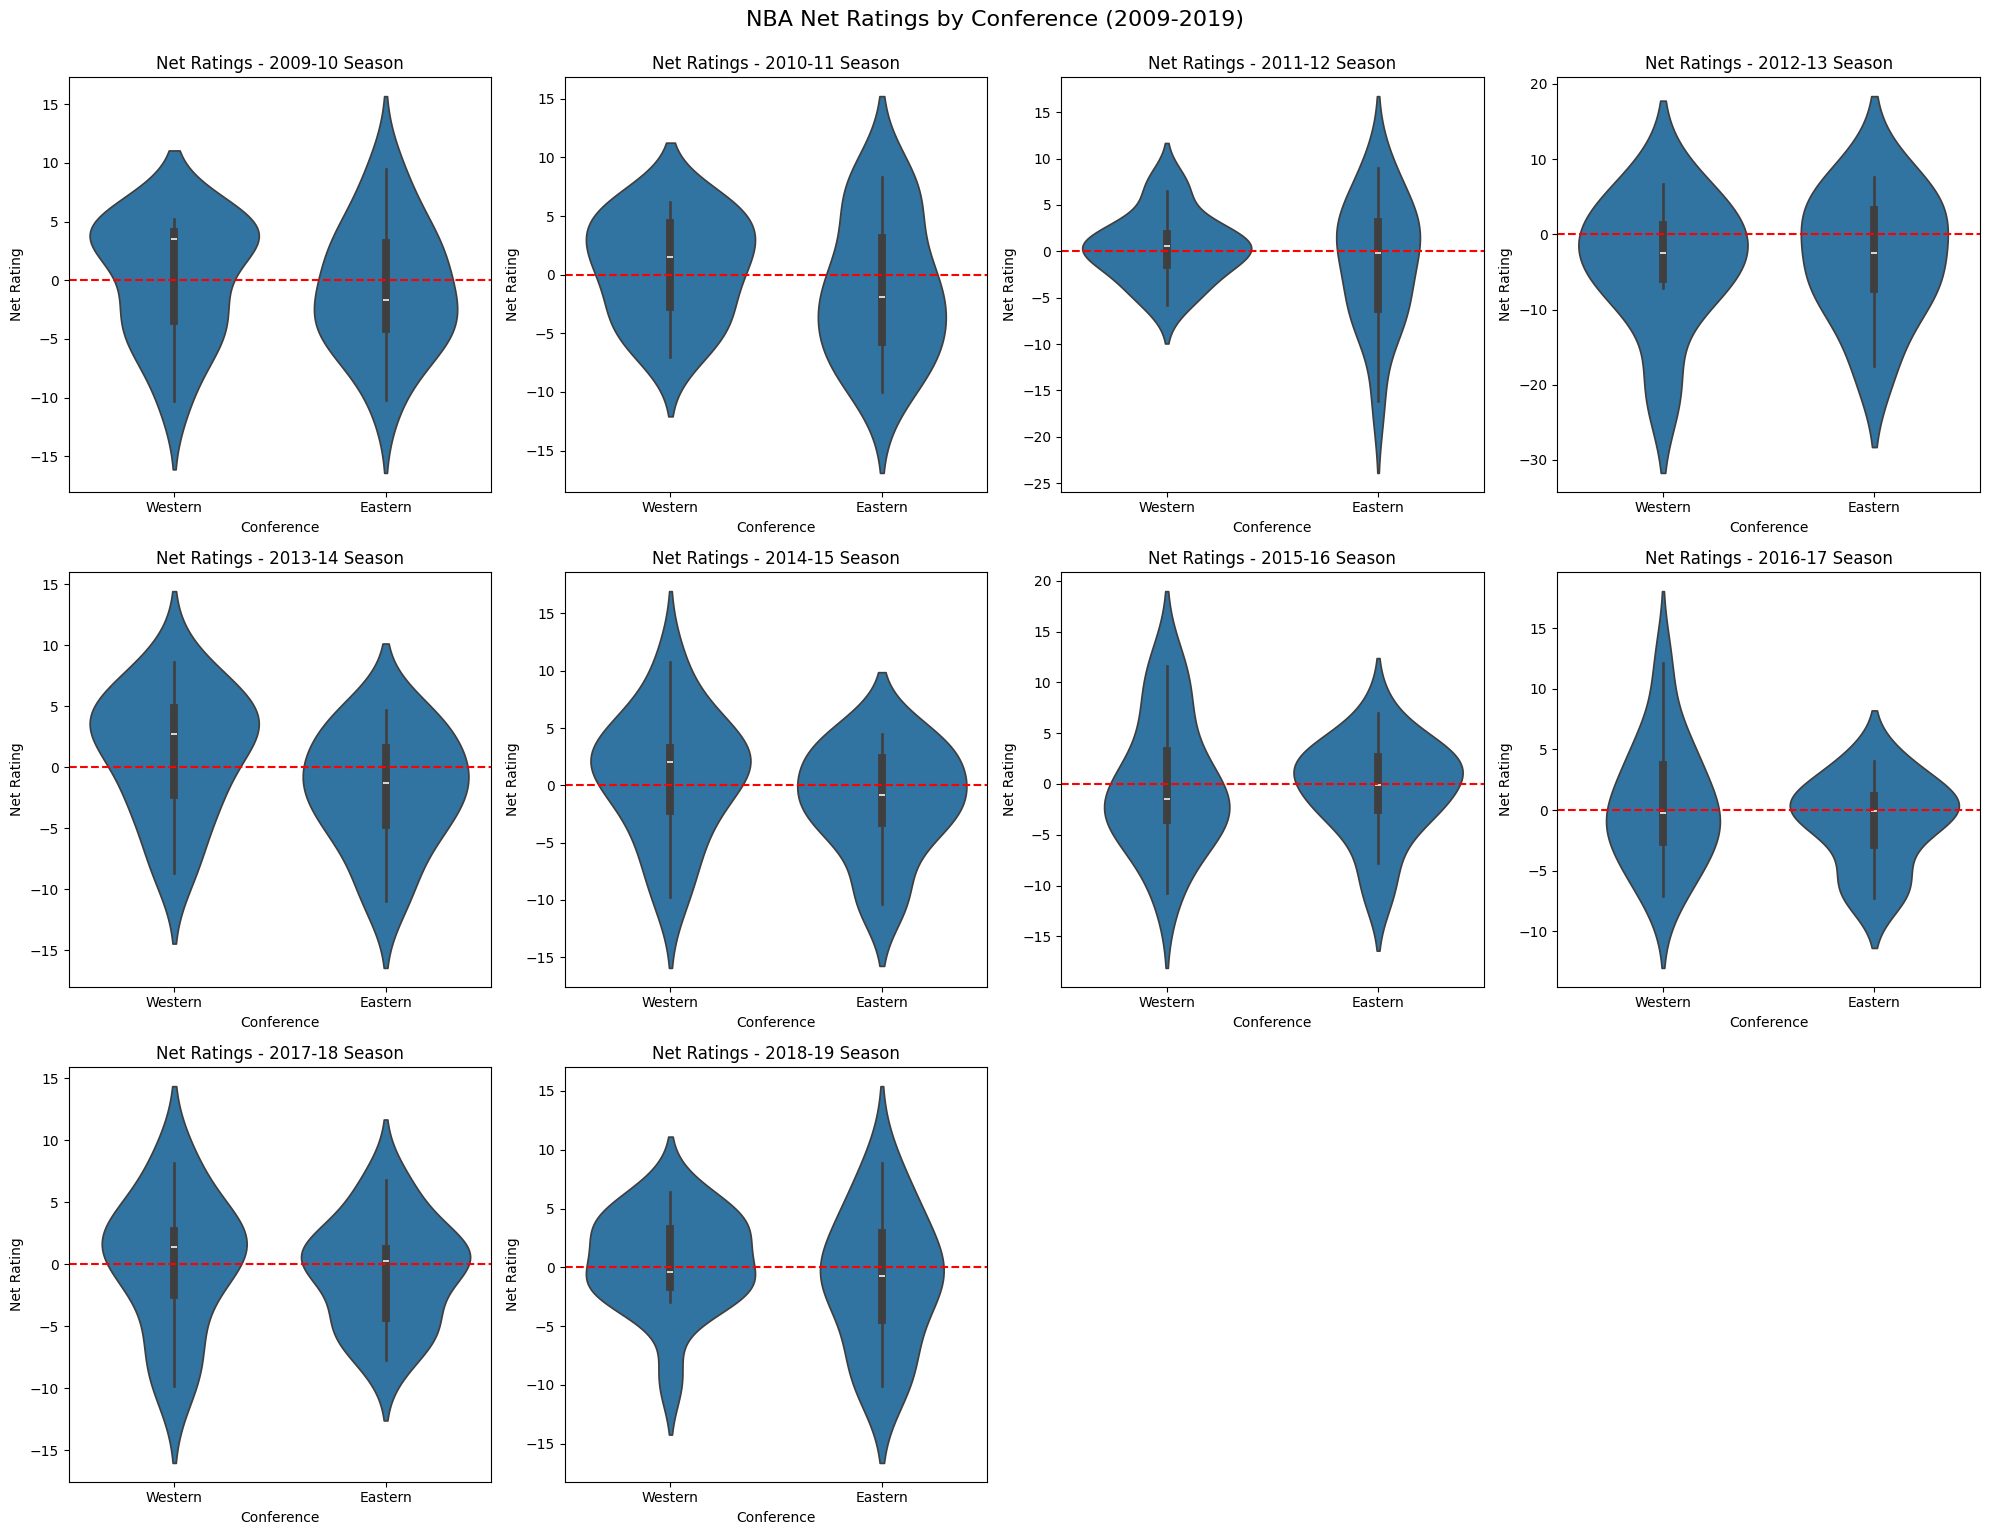

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create violin plots
def create_net_rating_violin_plots(seasons_dict):
    # Prepare data for plotting
    plot_data = []
    for season, teams in seasons_dict.items():
        for team in teams:
            plot_data.append({
                'Season': season,
                'Conference': team['conference'],
                'Net Rating': team['average_net_rating']
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(plot_data)
    
    # Create a figure with subplots
    plt.figure(figsize=(20, 15))
    
    # Iterate through each season and create a subplot
    for i, season in enumerate(sorted(seasons_dict.keys()), 1):
        plt.subplot(3, 4, i)
        
        # Filter data for current season
        season_data = df[df['Season'] == season]
        
        # Create violin plot
        sns.violinplot(x='Conference', y='Net Rating', data=season_data)
        
        plt.title(f'Net Ratings - {season} Season')
        plt.xlabel('Conference')
        plt.ylabel('Net Rating')
        plt.axhline(y=0, color='r', linestyle='--')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.suptitle('NBA Net Ratings by Conference (2009-2019)', fontsize=16, y=1.02)
    plt.savefig('nba_net_ratings_violin_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Run the plot generation
create_net_rating_violin_plots(seasons_dict)


[0.5 0.  1.  1. ]
[ 1.39748353e-17 -2.40677719e-17] 2.220692927192916 1.7517222733970585 -135.0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

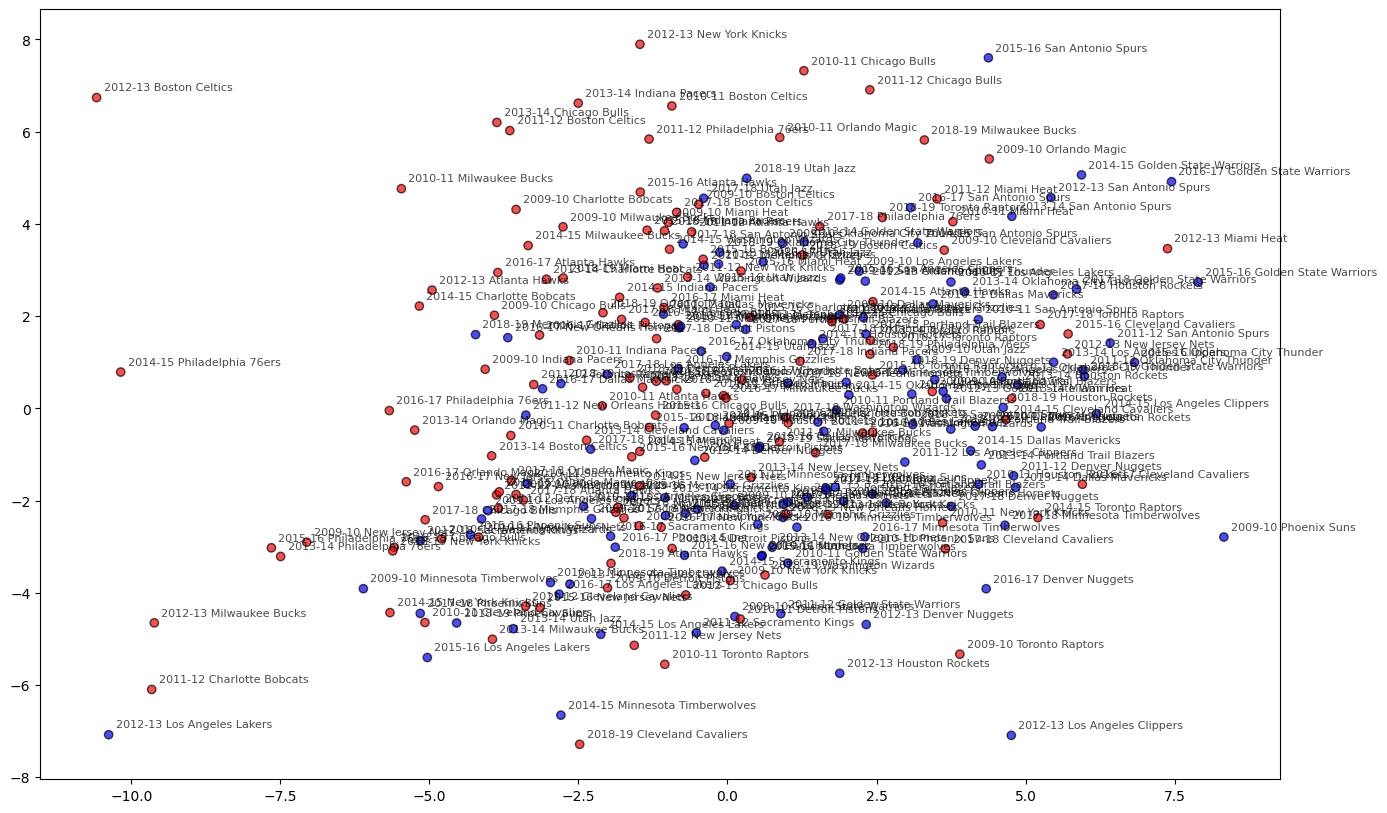

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Remove 'color' from kwargs to avoid passing it as a positional argument
    color = kwargs.pop('color', None)
    print(color)
    
    for nsig in range(1, 4):
        ellipse = Ellipse(xy=position, width=nsig * width, height=nsig * height, angle=angle)
        
        # Set color after creating the Ellipse
        if color:
            ellipse.set_color(color)
        
        # Apply any remaining kwargs
        for key, value in kwargs.items():
            ellipse.set_properties(**{key: value})
        
        ax.add_patch(ellipse)

def perform_gmm_clustering(seasons_dict):
    # Aggregate data across all seasons
    all_teams_data = []
    for season, teams in seasons_dict.items():
        # Add season information to each team
        for team in teams:
            team_data = team.copy()
            team_data['team'] = season + ' ' + team['team']
            all_teams_data.append(team_data)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_teams_data)
    
    # Prepare data for clustering
    X = df[['relative_offensive_rating', 'relative_defensive_rating']].copy()
    
    # Invert defensive rating (as lower is better for defense)
    X['relative_defensive_rating'] = -X['relative_defensive_rating']
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform GMM clustering with more robust model selection
    n_components_range = range(1, 7)
    models = [GaussianMixture(n_components=n, random_state=42).fit(X_scaled) for n in n_components_range]
    
    # Calculate BIC and AIC
    bic = [model.bic(X_scaled) for model in models]
    aic = [model.aic(X_scaled) for model in models]
    
    # Select optimal number of clusters
    optimal_clusters_bic = n_components_range[np.argmin(bic)]
    optimal_clusters_aic = n_components_range[np.argmin(aic)]
    
    # Fit final GMM with BIC-selected clusters
    gmm = GaussianMixture(n_components=optimal_clusters_bic, random_state=42)
    gmm.fit(X_scaled)
    
    # Predict cluster labels
    labels = gmm.predict(X_scaled)
    
    # Create visualization
    plt.figure(figsize=(16, 10))
    
    # Color and marker mapping
    color_map = {'Western': 'blue', 'Eastern': 'red'}
    
    # Improved scatter plot with cluster coloring
    for cluster in range(optimal_clusters_bic):
        cluster_mask = (labels == cluster)
        cluster_data = X[cluster_mask]
        cluster_df = df[cluster_mask]
        
        plt.scatter(
            cluster_data['relative_offensive_rating'], 
            cluster_data['relative_defensive_rating'],
            c=[color_map[conf] for conf in cluster_df['conference']],
            marker='o',
            alpha=0.7,
            label=f'Cluster {cluster}',
            edgecolors='black',
            linewidth=1
        )
    
    # Add team labels
    for i in range(len(X)):
        plt.annotate(
            df.iloc[i]['team'], 
            (X.iloc[i]['relative_offensive_rating'], X.iloc[i]['relative_defensive_rating']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.7
        )
    
    
    # Plot cluster centers
    cluster_centers = scaler.inverse_transform(gmm.means_)
    colors = cm.rainbow(np.linspace(0, 1, optimal_clusters_bic))
    
    # In your plotting loop:
    for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        if covar.shape == (2, 2):
            draw_ellipse(mean, covar, alpha=0.2, color=colors[i])
    
    plt.scatter(
        cluster_centers[:, 0], 
        -cluster_centers[:, 1],  
        c='green', 
        s=300, 
        alpha=0.8, 
        marker='x',
        label='Cluster Centers',
        linewidth=2,
        edgecolors='black'
    )
    
    plt.title(f'NBA Teams Clustering\nGMM with {optimal_clusters_bic} Clusters (BIC)', fontsize=16)
    plt.xlabel('Offensive Rating', fontsize=12)
    plt.ylabel('Defensive Rating (Inverted)', fontsize=12)
    plt.legend(title='Clusters', loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('nba_gmm_clustering.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Detailed cluster analysis
    print(f"Optimal number of clusters (BIC): {optimal_clusters_bic}")
    print(f"Optimal number of clusters (AIC): {optimal_clusters_aic}")
    
    print("\nDetailed Cluster Centers:")
    for i, center in enumerate(cluster_centers):
        cluster_teams = df[labels == i]
        print(f"\nCluster {i}:")
        print(f"  Center - Offensive Rating: {center[0]:.2f}, Defensive Rating: {-center[1]:.2f}")
        print("  Teams:")
        for _, team in cluster_teams.iterrows():
            print(f"    {team['team']} ({team['conference']} Conference)")
        print(f"  Cluster Size: {len(cluster_teams)} teams")
    
    # Return additional information
    return {
        'labels': labels,
        'centers': cluster_centers,
        'optimal_clusters_bic': optimal_clusters_bic,
        'optimal_clusters_aic': optimal_clusters_aic
    }

# Assuming seasons_dict is already defined
# Run the clustering analysis
cluster_results = perform_gmm_clustering(seasons_dict)